# Non-Private Centralized Logistic Regression

In [1]:
# add files that we need!
import os
import sys
import logging 
logger = logging.getLogger()

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from src.model.logistic_regression_models import MeanFieldMultiDimensionalLogisticRegression
from src.privacy_accounting.optimizer.standard_optimizer import StandardOptimizer
from src.privacy_accounting.analysis.moment_accountant import compute_eps_from_ledger


import torch
import torch.optim as optim

import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

# plotting
%matplotlib inline

In [3]:
prior_params = {
    "w_nat_mean": np.array([0.0, 0.0], dtype=np.float64),
    "w_pres": np.array([0.1, 0.1], dtype=np.float64) 
}

# initally local likelihood is zero - init at the prior!
current_params = prior_params 

hyperparameters = {
    "n_in": 2,
    "N_samples": 50,
    "N_steps": 500,
    "base_optimizer_class": optim.SGD,
    "base_optimizer_parameters": {'lr': 0.02},
    "wrapped_optimizer_class": StandardOptimizer,
    "wrapped_optimizer_parameters": {},
}

logRegressionModel = MeanFieldMultiDimensionalLogisticRegression(current_params, hyperparameters)

In [4]:
data_x = np.array([[2, 2], [1, 1], [0, 1], [1, 0], [-0.5, 0.1], 
                       [-1, -1], [-2, -2], [0, -1], [-1, 0],
                       [0.5, 0.1]], dtype=np.float64)
data_y = np.array([1, 1, 1, 1, 1, -1, -1, -1, -1, -1], dtype=np.float64)

def plot_results(data_x, data_y, opt_params):
    x_vals = data_x[:, 0]
    y_vals = data_x[:, 1]
    labels = data_y
    plt.figure()
    plt.grid(b=True)
    plt.scatter(x_vals, y_vals, c = labels)

    w_map = opt_params['w_nat_mean']/opt_params['w_pres']
    plt.arrow(0, 0, w_map[0], w_map[1], head_width=0.1)
    plt.plot([-2, 2], [(w_map[0]/w_map[1])*2, (w_map[0]/w_map[1])*-2])
    plt.show()
    
def plot_training(training_array):
    x_vals = np.arange(1, training_array.size+1)
    plt.figure()
    plt.plot(x_vals, training_array)
    plt.ylabel('ELBO Loss')
    plt.xlabel('Step')
    plt.show()
    
data = {
    "X": data_x,
    "y": data_y,
}

t = {
    "w_nat_mean": np.array([0, 0]),
    "w_pres": np.array([0, 0]) 
}


In [5]:
opt_params, training_curve = logRegressionModel.fit(data, t, prior_params, hyperparameters)

Loss: 17.016 after 0 steps
Loss: 6.159 after 25 steps
Loss: 5.646 after 50 steps
Loss: 4.817 after 75 steps
Loss: 4.690 after 100 steps
Loss: 4.834 after 125 steps
Loss: 4.719 after 150 steps
Loss: 4.861 after 175 steps
Loss: 4.634 after 200 steps
Loss: 4.659 after 225 steps
Loss: 5.146 after 250 steps
Loss: 5.102 after 275 steps
Loss: 4.767 after 300 steps
Loss: 4.786 after 325 steps
Loss: 5.174 after 350 steps
Loss: 4.668 after 375 steps
Loss: 4.830 after 400 steps
Loss: 4.608 after 425 steps
Loss: 4.667 after 450 steps
Loss: 4.623 after 475 steps


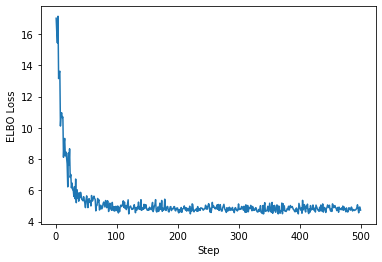

In [6]:
plot_training(training_curve)

{'w_nat_mean': array([0.82483934, 1.30322938]), 'w_pres': array([0.68839041, 0.40978734])}


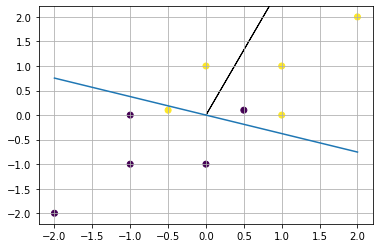

In [7]:
print(opt_params)
plot_results(data_x, data_y, opt_params)

## Let's use DP-SGD Instead!

In [8]:
from src.privacy_accounting.optimizer.dp_optimizer import DPGaussianOptimizer
from src.privacy_accounting.analysis import PrivacyLedger

ledger = PrivacyLedger(data_x.shape[0], 1)

hyperparameters = {
    "n_in": 2,
    "N_samples": 100,
    "N_steps": 1000,
    "base_optimizer_class": optim.SGD,
    "base_optimizer_parameters": {'lr': 0.01},
    "wrapped_optimizer_class": DPGaussianOptimizer,
    "wrapped_optimizer_parameters": {
                                     'l2_norm_clip':5.0,
                                     'noise_multiplier': 1,
                                     'num_microbatches': None,
                                     'ledger': ledger,
                                    }
}

logRegressionModel = MeanFieldMultiDimensionalLogisticRegression(current_params, hyperparameters)

/Users/msharma/workspace/DP-PVI/src/utils/torch_nest_utils.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  group_grads.append(operation(*ps))


Loss: 16.051 after 0 steps
Loss: 7.392 after 50 steps
Loss: 5.680 after 100 steps
Loss: 5.430 after 150 steps
Loss: 5.381 after 200 steps
Loss: 5.159 after 250 steps
Loss: 5.319 after 300 steps
Loss: 4.881 after 350 steps
Loss: 4.938 after 400 steps
Loss: 4.943 after 450 steps
Loss: 4.950 after 500 steps
Loss: 5.392 after 550 steps
Loss: 4.648 after 600 steps
Loss: 4.900 after 650 steps
Loss: 4.957 after 700 steps
Loss: 4.834 after 750 steps
Loss: 4.979 after 800 steps
Loss: 4.601 after 850 steps
Loss: 5.176 after 900 steps
Loss: 5.118 after 950 steps


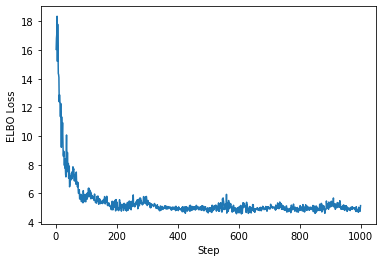

In [9]:
opt_params, training_curve = logRegressionModel.fit(data, t, prior_params, hyperparameters)
plot_training(training_curve)

{'w_nat_mean': array([0.80450587, 1.51514535]), 'w_pres': array([0.55971272, 0.41423884])}


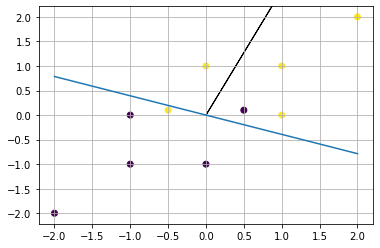

In [10]:
print(opt_params)
plot_results(data_x, data_y, opt_params)

## How private are we?
Let's compute an $(\epsilon, \delta)$ guarantee. It is required that $\delta << \frac{1}{N} = 0.1$, let's choose $\delta = 10^{-3}$

In [11]:
eps = compute_eps_from_ledger(ledger, 1e-3)

In [12]:
print(eps)

1006.9077552789821


Given no optimisation has been performed for privacy performance, and the total lack of subsampling, this incredibly weak privacy guarantee is not so surpising. 